# Deep Image Prior (DIP) for PAM
## Tri Vu - Updated 051620

### Import libs and utils

In [1]:
import keras
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import numpy as np
from define_model import *
from build_unet import *
from keras.optimizers import Adam
import os
import time
import PIL

Using TensorFlow backend.
C:\Users\Tri Vu\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Tri Vu\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Tri Vu\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Tri Vu\AppData

In [2]:
def constructPlot(data, title, fsize=(10,6), cmax=None):
    """ Construct subplots based on the stacked matrices and its corresponded label 
        NOTE: title[0] is the main title. title[i] is the """
    fig = plt.figure(figsize=fsize)
    for i in range(data.shape[2]):
        ax = fig.add_subplot(1,data.shape[2],i+1)
        plt.imshow(np.rot90(data[:,:,i]), 
                   interpolation='nearest', aspect='auto', cmap='gray')
        plt.axis('off')
        if cmax is not None:
            plt.clim(data[:,:,i].min(), cmax)
#         plt.ylim(ax_length_mm[-1],5)
#         if i == 0:
#             plt.ylabel('Axial Direction (mm)', fontsize=15)
#         plt.xlabel('Lateral Direction (mm)', fontsize=15)
        ax.set_title(title[i+1], fontsize=15)  
    
    plt.suptitle(title[0], fontsize=20)
    plt.show()

### Read sample images

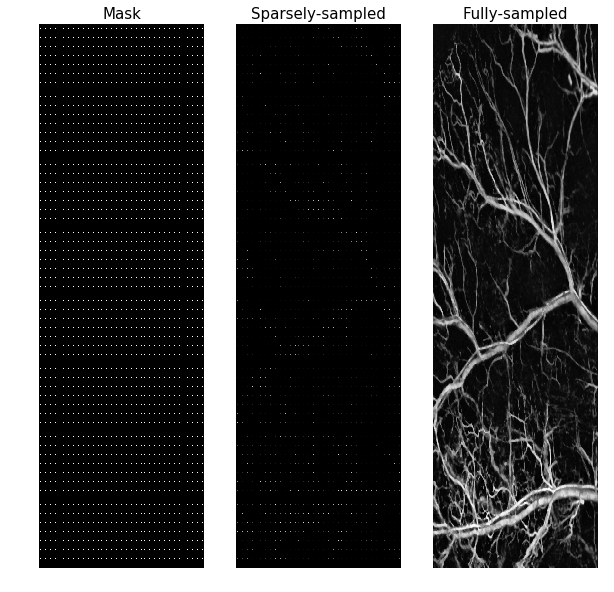

In [3]:
imgpath = './Data/'
imgname = '20190524_ear_drug   8_Image0_index0_pad_5-10'
imgsuffix = '.png'
im = cv2.imread(imgpath + imgname + imgsuffix)

# im = im[:, 300:1000, :]
# im = im[:, 500:900, :]
# mask = [3, 7]

constructPlot(im, ['', 'Mask', 'Sparsely-sampled', 'Fully-sampled'], fsize=(10,10))

In [4]:
im.shape

(499, 1200, 3)

### The next code briefly try the deep prior implement by Kosugi: https://github.com/satoshi-kosugi/DeepImagePrior/blob/master/denoising.py

In [5]:
im_mask = im[:, :, 0]
im_masked = im[:, :, 1]
im_gt = im[:, :, 2]

# plt.imshow(im[:, :, 0])
# im = im.astype(np.uint8)

In [6]:
# # Zero-pad fully-sampled image to make sure that it is integer-factor bigger than down-sampled image (this is only for 
# # original SR method by Satoshi et al.; comment out for our SR method)
# h_factor, l_factor = round(im_gt.shape[0]/im_down.shape[0]), round(im_gt.shape[1]/im_down.shape[1])
# im_gt_temp = np.zeros((im_down.shape[0]*h_factor, im_down.shape[1]*l_factor))
# im_gt_temp[:im_gt.shape[0], :im_gt.shape[1]] = im_gt
# im_gt = im_gt_temp

# # Crop the fully-sampled image with multiplier of 2^4 as the spatial size
# im_gt = im_gt[:im_gt.shape[0]-(im_gt.shape[0] % (16*mask[0])), 
#               :im_gt.shape[1]-(im_gt.shape[1] % (16*mask[1]))] # enforce size that contains 2^4 in multiplication 
#                                                     # to prevent trouble with max pooling in the Unet  
# im_mask = im_mask[:im_gt.shape[0], :im_gt.shape[1]]
# im_masked = im_masked[:im_gt.shape[0], :im_gt.shape[1]]

# plt.imshow(im_gt)
# plt.show()

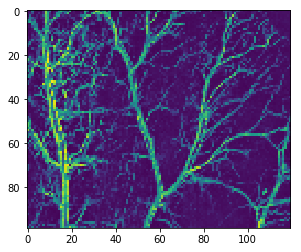

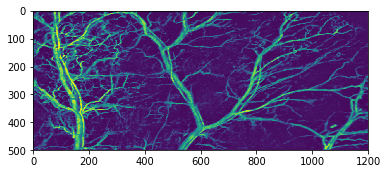

In [7]:
# Get the down-sampled image
im_down = im_masked[im_mask!=0];
[x_down, y_down] = np.where(im_mask!=0);
x_down = np.unique(x_down);
y_down = np.unique(y_down);
im_down = im_down.reshape(len(x_down), len(y_down));
plt.imshow(im_down)
plt.show()

plt.imshow(im_gt)
plt.show()

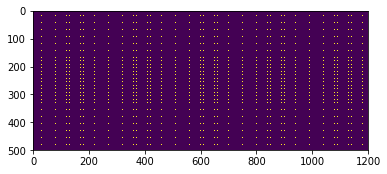

In [8]:
plt.imshow(im_mask)

In [9]:
## For denoising method
# def squared_error(y_true, y_pred):
#     return K.sum(K.square(y_pred - y_true))


# def define_denoising_model(height, width):
#     num_u = [128, 128, 128, 128, 128]
#     num_d = [128, 128, 128, 128, 128]
#     kernel_u = [3, 3, 3, 3, 3]
#     kernel_d = [3, 3, 3, 3, 3]
#     num_s = [4, 4, 4, 4, 4]
#     kernel_s = [1, 1, 1, 1, 1]
#     lr = 0.1
#     inter = "bilinear"

#     model = define_model(num_u, num_d, kernel_u, kernel_d, num_s, kernel_s, height, width, inter, lr)
#     model.compile(loss=squared_error, optimizer=Adam(lr=lr))
#     print(model)

#     return model


# def denoising(image, iter=1000):
#     height, width = image.shape[:2]
#     model = define_denoising_model(height, width)
# #     for layer in model.layers:
# #         print(layer.output_shape)
#     input_noise = np.random.uniform(0, 0.1, (1, height, width, 32)) + np.random.normal(0, 1/30.0, (height, width, 32))
#     image = image.reshape(np.append(np.asarray(image.shape), 1))
# #     print(image.shape)
#     l = []

#     for i in range(iter):
#         loss = model.train_on_batch(input_noise, image[None, :, :, :])
#         l.append(loss)
#         print(str(i))
#         if i % 100 == 0:
#             test_im = np.clip(model.predict(image[None, :, :, :])[0], 0, 255).astype(np.uint8)
#             plt.imshow(np.squeeze(test_im))
#             plt.show()

#     return np.clip(model.predict(image[None, :, :, :])[0], 0, 255).astype(np.uint8), l, model

In [10]:
# def define_inpainting_model(height, width):
#     num_u = [128, 128, 128, 128, 128]
#     num_d = [128, 128, 128, 128, 128]
#     kernel_u = [3, 3, 3, 3, 3]
#     kernel_d = [3, 3, 3, 3, 3]
#     num_s = [0, 0, 0, 0, 0]
#     kernel_s = [0, 0, 0, 0, 0]
#     lr = 0.01
#     inter = "bilinear"

#     base_model = define_model(num_u, num_d, kernel_u, kernel_d, num_s, kernel_s, height, width, inter, lr, input_channel=2)

#     masked_image = Input(shape=(height, width, 1))
#     mask_image = Input(shape=(height, width, 1))

#     loss = Lambda(lambda x: K.sum(K.square((x[0] - x[1]) * x[2]), axis=-1))([base_model.output, masked_image, mask_image])

#     model = Model([base_model.input, masked_image, mask_image], loss)
# #     model.compile(loss="mean_absolute_error", optimizer=Adam(lr=lr))
#     model.compile(loss=squared_error, optimizer=Adam(lr=lr), metrics=['mse'])

#     return model, base_model


# def inpainting(masked_image, mask_image, iter=1000):
#     height, width = masked_image.shape[:2]
#     model, base_model = define_inpainting_model(height, width)
#     masked_image = masked_image.reshape(np.append(np.asarray(masked_image.shape), 1))
#     mask_image = mask_image.reshape(np.append(np.asarray(mask_image.shape), 1))

#     y = np.linspace(0.0, 1.0, height)
#     x = np.linspace(0.0, 1.0, width)
#     XX, YY = np.meshgrid(x, y)
#     input_meshgrid = np.concatenate([XX[:,:,None], YY[:,:,None]], axis=2)
#     l = []
    
#     initialTime = time.time()
#     for i in range(iter):
# #         loss = model.train_on_batch([input_meshgrid[None, :, :, :], masked_image[None, :, :, :],
# #                               mask_image[None, :, :, :]], np.zeros((1, height, width)))
#         loss = model.train_on_batch([input_meshgrid[None, :, :, :], masked_image[None, :, :, :],
#                               mask_image[None, :, :, :]], masked_image.reshape(1,height,width))
#         l.append(loss)
#         if i % 500 == 0:
#             test_im = np.clip(base_model.predict(input_meshgrid[None, :, :, :])[0], 0, 255).astype(np.uint8)
#             plt.imshow(np.squeeze(test_im))
#             plt.show()
#             print(str(i))

#     inpainted_image = np.clip(base_model.predict(input_meshgrid[None, :, :, :])[0], 0, 255).astype(np.uint8)
    
#     totalTrainingTimeHr = (time.time() - initialTime) / 60
#     return inpainted_image, l, model, totalTrainingTimeHr

# # noisy_image = im[:, :, 1]
# # [denoised_image, l, model] = denoising(noisy_image, iter=2000)
# masked_image = im[:, :, 1]
# mask_image = im[:, :, 0]
# [inpainted_image, l, model, totalTrainingTimeHr] = inpainting(masked_image, mask_image, iter=5000)
# print('Done')

(499, 1200, 1)


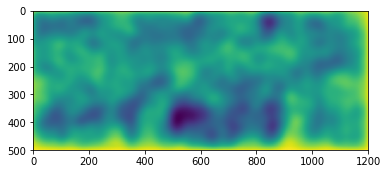

0


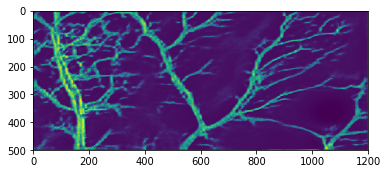

500


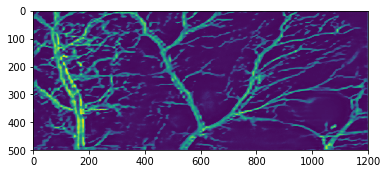

1000


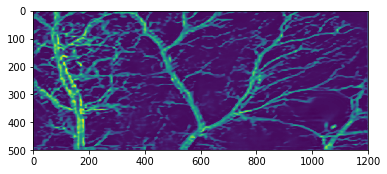

1500


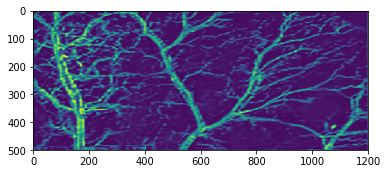

2000


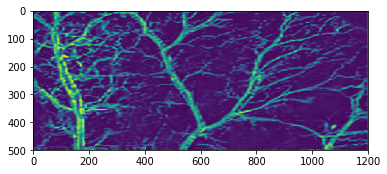

2500
Done


In [11]:
def ssim_loss(y_true, y_pred):
#     print(y_true.shape)
    return 10*tf.reduce_mean(tf.image.ssim(y_pred, y_true, max_val=255))

def squared_error(y_true, y_pred):
    return K.sum(K.square(y_pred - y_true))

def define_super_resolution_model(height, width, height_lr, width_lr, h_factor, l_factor, kernel_size, input_depth=32):
    img_shape = (height, width, input_depth)
    num_u = [128, 128, 128, 128, 128]
    num_d = [128, 128, 128, 128, 128]
    kernel_u = [3, 3, 3, 3, 3]
    kernel_d = [3, 3, 3, 3, 3]
    num_s = [4, 4, 4, 4, 4]
    kernel_s = [1, 1, 1, 1, 1]
    lr = 0.1
    inter = None  # apply reflection padding. THIS IS VERY CRUCIAL to have desired output
    
    """ WARNING: transposed convolution for upsampling appears to cause severe checkerboard artifact: 
        https://distill.pub/2016/deconv-checkerboard/ - avoid using conv2dtranspose in nn """

    base_model = define_model(num_u, num_d, kernel_u, kernel_d, num_s, kernel_s, height, width, inter, lr)
    
    mask = Input(shape=(height, width,1))
#     base_model = build_unet(img_shape, kernel_size)

#     lanczos_kernel = np.zeros((h_factor,l_factor))
#     for i in range(h_factor):
#         for j in range(l_factor):
#             x_d = np.abs(j-1.5)
#             y_d = np.abs(i-1.5)
#             lanczos_kernel[i,j] = np.sinc(x_d) * np.sinc(x_d/2.0) + np.sinc(y_d) * np.sinc(y_d/2.0)
#     lanczos_kernel = lanczos_kernel / lanczos_kernel.sum()

#     x = base_model.output
#     down_sampled = Lambda(lambda x: K.zeros_like(x[:, ::h_factor, 
#                                                    ::l_factor, :]))(x)

# #     for i in range(h_factor):
# #         for j in range(h_factor):
# #             down_sampled = Lambda(lambda x: tf.image.resize_images(x[0][:, i::h_factor, j::l_factor, :] * 
# #                                   lanczos_kernel[i, j], [height_lr, width_lr], method=tf.image.ResizeMethod.BICUBIC) + 
# #                                   x[1])([x, down_sampled])
#     for i in range(h_factor):
#         for j in range(h_factor):
#             down_sampled = Lambda(lambda x: x[0][:, i::h_factor, j::l_factor, :] * lanczos_kernel[i, j] + 
#                                   x[1])([x, down_sampled])

#     down_sampled = Conv2D(filters=1, kernel_size=9, 
#                           strides=(h_factor, l_factor), padding='same')(base_model.output)
#     down_sampled = BatchNormalization()(down_sampled)
#     down_sampled = Conv2D(filters=1, kernel_size=9, 
#                           strides=1, padding='same', activation='relu')(down_sampled)

#     down_sampled = Lambda(lambda x: tf.image.resize_images(x, [round(height/h_factor), round(width/l_factor)],
#                                   method=tf.image.ResizeMethod.NEAREST_NEIGHBOR))(base_model.output)
    
    down_sampled = multiply([mask, base_model.output])

#     print(down_sampled.shape, base_model.output.shape)
    model = Model([base_model.input, mask], down_sampled)
#     model = Model(base_model.input, base_model.output)
    model.compile(loss='mse', optimizer=Adam(lr=lr))

    return model, base_model


def super_resolution(image, full_sampled, mask, iter=5000):
    input_depth = 32 # check out the paper
    height_lr, width_lr = image.shape[:2]
    height, width = full_sampled.shape[:2]
    h_factor, l_factor = round(height/height_lr), round(width/width_lr)
#     kernel_size = (h_factor, l_factor)
    kernel_size = 3
    model, base_model = define_super_resolution_model(height, width, height_lr, width_lr, h_factor, l_factor, 
                                                      kernel_size, input_depth)
    input_noise = np.random.uniform(0, 0.1, (1, height, width, input_depth))
    image = image.reshape(np.append(np.asarray(image.shape), 1))
    mask = mask.reshape(np.append(np.asarray(mask.shape), 1))
    mask = mask/255
    l = []
    
    print(mask.shape)
    initialTime = time.time()
    for i in range(iter):
        loss = model.train_on_batch([input_noise + np.random.normal(0, 1/20.0, (height, width, input_depth)), 
                                     mask[None, :, :, :]], 
                                    image[None, :, :, :])
        l.append(loss)
        if i % 500 == 0:
            test_im = base_model.predict(input_noise)
            plt.imshow(np.squeeze(test_im))
            plt.show()
            print(str(i))
    
    sr_image = base_model.predict(input_noise)
    totalTrainingTimeHr = (time.time() - initialTime) / 60
    return sr_image, l, model, totalTrainingTimeHr, input_noise

[sr_image, l, model, totalTrainingTimeHr, input_noise] = super_resolution(im_masked, im_gt, im_mask, iter=3000)
print('Done')

In [12]:
temp = np.squeeze(sr_image)
im[:, :, 1] = temp.astype(np.uint8)

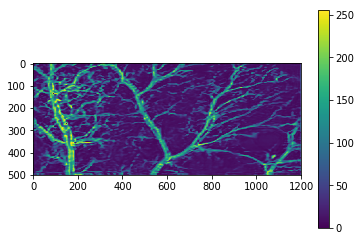

In [13]:
plt.imshow(np.squeeze(im[:, :, 1]))
plt.colorbar()
plt.show()

### Save model and image

In [14]:
model.save(imgpath + imgname + '.h5')

In [15]:
cv2.imwrite(imgpath + imgname + '_dip_out.png', im)

True

In [16]:
np.savetxt(imgpath + imgname + '_loss.txt', np.asarray(l))

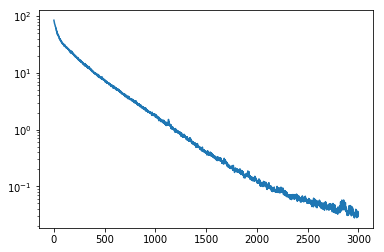

In [17]:
plt.plot(l)
plt.yscale('log')

In [18]:
np.savetxt(imgpath + imgname + '_trainingtime.txt', np.asarray([totalTrainingTimeHr]))

In [19]:
totalTrainingTimeHr

62.41836870511373

In [20]:
plt.imshow(np.squeeze(inpainted_image))
plt.show()

NameError: name 'inpainted_image' is not defined